# AI CUP 2020 [愛文芒果不良品分類競賽](https://aidea-web.tw/topic/fee8b6d6-dbd1-4794-a091-fa2ad829ea14) 

> This tutorial only provides **toy data**, please download **full data** from the official website, and put them in the corresponding path.

This is a multi-label classification task, each image may contain mulitple types (can either be same or different) of defective. 
This document contains 3 parts:
1. **Data format** introduction
2. **Data preprocessing** example
3. A *simple* **baseline** (ML base) example, official baseline are also provided as pdf file
4. More about **Development** and **Evaluation** 

## 1. Data Format
* There are **Training** data and **Development** data, all data is under the directory **./C2_TrainDev_Toy/**
* Image files are under **./C2_TrainDev_Toy/Train/** and **./C2_TrainDev_Toy/Dev/**, all images are in **.jpg** format
* Label files are under **./C2_TrainDev_Toy/**, both **training** and **dev** data are in **.csv** format

### 1.1 Image file
Images size are usually 1280px * 720px (some of them are not)

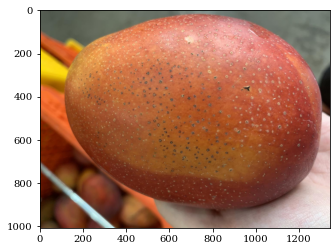

In [5]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=10)

img_path = glob('./C2_TrainDev_Toy/Train/*.*')[-1]
curr_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(curr_img)
plt.show()

### 1.2 Label file
Each row represents one data, containing a **image id (path)** and single(or multiple) **defective bounding box information** (x, y coordinate, width, length, and its defective label)

In [6]:
import pandas as pd

pd.read_csv('./C2_TrainDev_Toy/train.csv', header=None)
pd.read_csv('./C2_TrainDev_Toy/dev.csv', header=None)

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,26519.jpg,559,772,233,413,不良-機械傷害,848.0,539.0,102.0,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39995.jpg,376,481,103,88,不良-機械傷害,615.0,612.0,46.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40837.jpg,854,248,132,238,不良-機械傷害,743.0,587.0,32.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22304.jpg,723,693,399,108,不良-機械傷害,779.0,598.0,27.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40077.jpg,437,362,359,163,不良-黑斑病,772.0,355.0,476.0,391.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16613.jpg,431,148,221,213,不良-乳汁吸附,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,06930.jpg,559,415,75,106,不良-乳汁吸附,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,31997.jpg,604,264,101,130,不良-乳汁吸附,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,07440.jpg,557,73,219,166,不良-乳汁吸附,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Preprocessing 
This example shows a function loads the label file and turns it into 3 list data. We also random pick one data to draw its bounding box on the image.

### 2.1 load csv into list data

In [13]:
import re
import numpy as np
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='./ukai.ttc', size=12) # for showing chinese character

def load_mango_csv(csv_path='./C2_TrainDev_Toy/train.csv'):
    path = []
    box = []
    label = []
    subdir = csv_path.split('/')[-1].split('.')[0].capitalize()
    with open(csv_path, 'r', encoding='utf8') as f:        
        for line in f:
            clean_line = re.sub(',+\n', '', line).replace('\n', '').replace('\ufeff', '').split(',')
            curr_img_path = f'./C2_TrainDev_Toy/{subdir}/{clean_line[0]}'
            curr_info = np.array(clean_line[1:]).reshape(-1, 5)
            curr_box = curr_info[:, :-1].astype('float16').tolist()
            curr_label = curr_info[:, -1].tolist()
            path.append(curr_img_path)
            box.append(curr_box)
            label.append(curr_label)
    return path, box, label

path, box, label = load_mango_csv(csv_path='./C2_TrainDev_Toy/train.csv')

# show first 3 data: its image path, bounding box, and label
print(path[:3])
print(box[:3])
print(label[:3])

['./C2_TrainDev_Toy/Train/38414.jpg', './C2_TrainDev_Toy/Train/03182.jpg', './C2_TrainDev_Toy/Train/29863.jpg']
[[[46.0, 146.0, 576.0, 574.0]], [[581.0, 277.0, 97.0, 93.0]], [[514.0, 538.0, 117.0, 144.0]]]
[['不良-機械傷害'], ['不良-機械傷害'], ['不良-機械傷害']]


### 2.2 draw bounding box on image

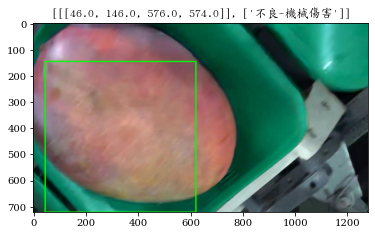

In [14]:
choose_idx = 0
curr_path, curr_box, curr_label = path[choose_idx], box[choose_idx], label[choose_idx]
curr_img = cv2.cvtColor(cv2.imread(curr_path), cv2.COLOR_BGR2RGB)

for box in curr_box:
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[0] + box[2]), int(box[1] + box[3]))
    curr_img = cv2.rectangle(curr_img, start_point, end_point, (0, 255, 0), 3)

plt.title([curr_box, curr_label], fontproperties=font)
plt.imshow(curr_img)
plt.show()

## 3. Baseline Method
In this part, we will provide a **baseline** method which is *only* based on **image preprocessing**, **feature extraction** and **machine learning algorithms**. The result is pretty bad actually, so of course you may use more advanced algorithms (e.g. those for object detection, such as YOLO, FasterRCNN ...) but we will not provide more information or tutorials about that.

### 3.1 Pipeline

1. Load training / development data
2. Basic Image Preprocessing
3. Use Histogram of Oriented Gradients (HOG) to extract feature
4. Use ANOVA univariate feature selection to reduce feature dimension
5. Feed the selected feature into a SVM model


* Note:
    * There are other Local features Descriptor such as SIFT, SURF, GLOH ...
    * Here is a more advanced [example](https://medium.com/@liverungrow/sift-bag-of-features-svm-for-classification-b5f775d8e55f) using SIFT+SVM for image classification 

### 3.2 Full Sample Code
Here we provide the code for a *complete* round of training and evaluating on a single defective type, you may use these code to help your development (or you want to write them yourself which is totally fine). Detailed explanation for each part of code is provided in the python script file.
<br><br>
\* The following code refers to [this website](https://rpubs.com/Sharon_1684/454441)

In [17]:
from hog_anova_svm import *

### Basic Usage ###
defective_type = '不良-乳汁吸附'
file_prefix = f'{defective_type.split("-")[-1]}'
HOG_ANOVA_SVM(file_prefix, defective_type, anova_percentile=5, slice_img=True, linear_svm=True)

build train data...
0
100
200
300
400
build dev data...
0
train linear svm model...
evaluating dev data...
[[54 26]
 [12  8]] 0.62 0.29629629629629634 0.23529411764705882 0.4


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## 4. More about Development and Evaluation


### 4.1 Development
For those who choose this task as your project, here is where (or how) to try out this task:
1. Use **google colab**, we will not provide GPU resource in this class.
2. Download the dataset from official site and upload it to your **google cloud**.
3. If you are lack of **google cloud storage** space, you can use a **gsuite** account.
4. **Mount** your google cloud (or gsuite) to google colab, then you may use those data on google colab.
5. Have Fun coding and modeling !!

### 4.2 Evaluation
And here is the grading criterion:
1. You will need to handover your google colab code so that we can **retrain** your model from beginning to end (including data preprocessing) and perform additional **independent tests** using your retrained model. 
> Please note that training the model on colab may be interrupted (shutdown) due to too long training time. If this happens unfortunately, this homework will be scored as 0.

2. Official leaderboard will be **available from 2020/12/31 to 2021/01/08**, part of final project score is based on the best score you get on the leaderboard.